In [18]:
from dataloader import load_data, balanced_sampler, display_face 
from os import listdir
import os, random, copy
from PIL import Image
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

##### k-fold Cross-Validation Functions #####

# Function to create k mutually exclusive sets from a dataset
# INPUT: images and number of k mutually exclusive sets
# OUTPUT: dictionary of k mutually exclusive sets with roughly same number of each category
def CrossFold(dataset, number, input_d):
    toReturn = defaultdict(list)
    targets = defaultdict(list)

    image_total=[]
    label_total=[]
    
    labels =[k for k,v in dataset.items()]
    numimages=len([x for x in dataset.values()][0])
    for i in range(numimages):
        for x in labels:
            image_total.append(dataset[x][i])
            label_total.append(x)
    image_split=np.array_split(image_total,number)
    label_split=np.array_split(label_total,number)

    for i in range(len(image_split)):
        toReturn[i]=image_split[i]
        targets[i]=[input_d[x] for x in label_split[i]]
    return toReturn,targets

# Function to check to make sure sets are mutually exclusive
# INPUT: k mutually exclusive sets (output from CrossFold)
# OUTPUT: Prints error to stdout if there not mutually exclusive
def CheckMutuallyExclusive(areMutuallyExclusive):
    for k,v in areMutuallyExclusive.items():
        #within a fold:
        for i in range(len(v)):
            toBeEvaluated = v[i]
            for j in range(i+1, len(v)):
                if(np.array_equal(toBeEvaluated,v[j])):
                    print("Well this sucks I have redundancies within a fold...")
        #between folds:
        for key,value in areMutuallyExclusive.items():
            if k == key:
                continue
            else:
                for i in range(len(v)):
                    for j in range(len(value)):
                        if np.array_equal(v[i], value[j]):
                            print("Son of a.... there are redundancies between folds")
                    
    return

###### PCA Functions #####
    
# Function to convert the Python dictionary loaded in by the dataloader.py load_data function 
# into a NumPy matrix for downstream manipulation
# Params:
# image_dict - Python dictionary with facial expressions as keys and a list NumPy arrays representing
#              image as values
# Return: A NumPy matrix of dimensions dxM denoting M images of d dimensions and the corresponding targets
def get_matrix(image_dict):
    image_matrix = []
    for emotion in image_dict:
        for image in image_dict[emotion]:
            image_matrix.append(np.concatenate(image))
    return np.matrix(image_matrix).T

# Function to apply PCA to a dxM image matrix, with M images each of dimension d
# Params:
# image_matrix - a dxM matrix representing M images each of dimension d (output of get_matrix)
# Return: the eigenvalues and principal components of the covariance matrix of the input
# eig_vals - the M eigenvalues of the MxM covariance matrix
# pcs - the M dx1 eigenvectors of the covariance matrix in the form of a dxM matrix
# Return: the M eigenvalues and M pcs from the covariance matrix calculated via PCA
def principal_components(image_matrix):
    mean_face = np.matrix.mean(image_matrix, axis = 1)
    centered_matrix = image_matrix - mean_face
    covariance_matrix = np.dot(centered_matrix.T, centered_matrix)/centered_matrix.shape[1]
    eig_vals, eig_vecs = np.linalg.eig(covariance_matrix)
    order = np.argsort(eig_vals)[::-1]
    eig_vals = eig_vals[order]
    eig_vecs = eig_vecs[:,order]
    pcs = np.dot(centered_matrix, eig_vecs)
    return(eig_vals, pcs)
    
# Function to project a dxM image matrix onto pcs calculate by PCA
# Params:
# mean_face - the average face calculate from averaging pixel values of training set
# image_matrix - the images to project in the from of a dxM matrix
# eig_vals - the eigenvalues calculated from PCA on the training set
# pcs - the pcs calculated from PCA on the training set
# k - the number of dimensions to keep
# Return: the dxM image matrix projected down to the kxM space
def project_k_dimensions(mean_face, image_matrix, eig_vals, pcs, k):
    centered_matrix = image_matrix - mean_face
    projections = np.dot(centered_matrix.T, pcs[:, 0:k])
    projections = projections/(np.linalg.norm(pcs[:, 0:k], axis = 0))/np.sqrt(eig_vals[0:k])
    return projections.T

##### Helper Functions

# INPUT: List of numpy arrays
# OUTPUT: list of flattened numpy arrays with a 1 to account for bias at the front 
def Transform(aSeriesOfUnfortunateEvents): #Flatten the numpy arrays and add a bias term to the front
    countOlaf = list()
    for baudelaire in aSeriesOfUnfortunateEvents:
        countOlaf.append(np.concatenate((np.array([1]), baudelaire.flatten())))
    return countOlaf 

def MatrixToListOfTransformedArrays(annoyingMatrix):
    return list(np.squeeze(np.asarray(annoyingMatrix)))

##### Softmax Regression Function #####

#one-hot encoding of y target
def one_hot(y):
    y=np.array(y)
    y_ = np.zeros((y.size, y.max()+1))
    y_[np.arange(y.size),y] = 1
    return(y_)

#define net input of matrix which is dot product of feature matrix and weights
def net_input(X, W):
    return (X.dot(W))

#define softmax function
def softmax(z):
    return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

#define functions to convert to class labels
def to_classlabel(z):
    return z.argmax(axis=1)

#compute cross entropy of a given output
def cross_entropy(output, y_target):
    return - np.sum(np.log(output) * (y_target),axis=1)

#compute the cost of a given output
def cost(output, y_target):
    return np.sum(cross_entropy(output, y_target))

#function to compute the sigmoid
def ComputeSigmoidFunction(func):
    if type(func) is np.ndarray:
        func = func[0]
    return 1/(1 + np.exp(-1 * func))

#compute the accuracy of a set of predictions
def accuracy(pred, actual):
    count=0
    for x in range(len(pred)):
        if to_classlabel(pred)[x]==to_classlabel(actual)[x]:
            count+=1
        else: pass
    return(count/len(pred))

# Function to perform batch gradient descent
def BatchGradient(faces, whereDoIBelong, weigh):
    prediction = (np.dot(faces,weigh))
    return np.dot((prediction-whereDoIBelong).T, faces).T

# Function to perform stochastic gradient descent
def StochasticGradient(faces, whereDoIBelong, weigh, alpha):
    W = weigh.copy()
    num_weights, num_classes = weigh.shape
    N = np.random.permutation(faces.shape[0])
    for i in N:
        prediction = np.dot(faces[i],W)
        W = W - alpha*np.dot(np.reshape(faces[i], (num_weights, 1)), np.reshape(prediction-whereDoIBelong[i], (1, num_classes)))
    return W

# INPUTS:
#1) A weight matrix
#2) The principal components 
#3) The number of principal components used for training (int)
#4) The first dimension of the image (224?) (int)
#5) The second dimension of the image (192?) (int)
#6) The emotion associated with these weights (str)
# OUTPUT: This function will plot the weight visualization for a particular emotion
def VisualizeWeights(weights, principalComponents, numPrincipalComponents, uno, dos, emotions):   
    plt.figure(figsize=(12,12))
    plt.title("Weight visualization of " + str(numPrincipalComponents) + " PCs")
    for k in range(len(emotions)):
        curr_weights = weights[:,k]
        freshPrinceOfBelAir = list()
        for i in range(numPrincipalComponents):
            freshPrinceOfBelAir.append(principalComponents[:, i] * curr_weights[i+1]) #i+1 to skip over the bias weight
        sauronOfMordor = freshPrinceOfBelAir[0]
        for i in range(1, len(freshPrinceOfBelAir)):
            sauronOfMordor += freshPrinceOfBelAir[i]
        minWeight = min(sauronOfMordor)
        sauronOfMordor = (sauronOfMordor - minWeight)
        maxWeight = max(sauronOfMordor)
        sauronOfMordor = sauronOfMordor*(256/maxWeight) 
        plt.subplot(1, len(emotions), k+1)
        plt.title(emotions[k])
        forPlotting = np.array(np.reshape(sauronOfMordor, (uno, dos)))
        img = Image.fromarray(forPlotting)
        plt.imshow(img)
        plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
        plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)     
    return

In [19]:
# Main function to complete all parts of #6 Softmax Regression
def softmax_regression(howManyPrincipalComponents, alpha, k, numEpochs):

    # Load in the dataset with all emotions
    dataset, cnt = load_data("./aligned/")
    images = balanced_sampler(dataset, cnt, emotions=['happiness', 'anger',"fear","surprise","sadness","disgust"])
    n1, n2 = dataset['anger'][0].shape
    
    # Map categories to numeric categories
    d = dict([(y,x) for x,y in enumerate(sorted(set(images.keys())))])
    
    # Randomly shuffle data to get new test set images
    [random.shuffle(v) for k,v in images.items()]
    
    # Cross fold to get 10 mututally exclusive sets
    splitEmUp, labels = CrossFold(images, k, d)
    CheckMutuallyExclusive(splitEmUp)    
    # Output lists for batch gradient descent, loss and accuracy
    trainingLossBatch = []
    validationLossBatch = []
    testLossBatch = []

    trainPerformanceBatch = []
    valPerformanceBatch = []
    testPerformanceBatch = []
    
    # Output lists for stochastic, loss and acuracy
    trainingLossStochastic = []
    validationLossStochastic = []
    testLossStochastic = []

    trainPerformanceStochastic = []
    valPerformanceStochastic = []
    testPerformanceStochastic = []
    
    # Output dataframe for confusion matrix
    df_conf_total=pd.DataFrame()
    
    # Loop through the k folds (10 in this case)
    for fold in range(k):
        
        # Create each dataset to train, validate and test on from the folds
        # we already split up
        trainData = defaultdict(list)
        trainLabels = []
        valData = defaultdict(list)
        valLabels = []
        testData = defaultdict(list)
        testLabels = []
        counter = 0 
        
        valData["val"] = splitEmUp[fold]
        testData["test"] = splitEmUp[(fold + 1) %k]
        counter = 0
        for key,v in splitEmUp.items():
            if (counter != fold) and (counter != (fold +1) %k):
                for val in v: 
                    trainData["train"].append(val)
                for el in labels[key]:
                    trainLabels.append(el)
                counter += 1
            elif(counter == fold):
                for el in labels[key]:
                    valLabels.append(el)
                counter += 1 
            else:
                for el in labels[key]:
                    testLabels.append(el)
                counter += 1
        
        # Check to make sure test and validation sets are same length
        if len(testLabels) != len(valLabels):
            print("Strange things are happening")
        
        # One-hot encode labels
        trainLabels=one_hot(trainLabels)
        valLabels=one_hot(valLabels)
        testLabels=one_hot(np.array(testLabels))
        
        # Create feature matrices for each set using dimensionality reduction via PCA
        trainingMatrix = get_matrix(trainData)
        eig_vals, pcs = principal_components(trainingMatrix)
        mean_face = np.matrix.mean(trainingMatrix, axis = 1)
        centered_matrix = trainingMatrix - mean_face

        projectedTrain = project_k_dimensions(mean_face, trainingMatrix, eig_vals, pcs, howManyPrincipalComponents).T
        projectedTrain = Transform(MatrixToListOfTransformedArrays(projectedTrain))
        projectedVal = project_k_dimensions(mean_face, get_matrix(valData), eig_vals, pcs, howManyPrincipalComponents).T
        projectedVal = Transform(MatrixToListOfTransformedArrays(projectedVal))
        projectedTest = project_k_dimensions(mean_face, get_matrix(testData), eig_vals, pcs, howManyPrincipalComponents).T
        projectedTest = Transform(MatrixToListOfTransformedArrays(projectedTest))

        projectedTrain=np.array(projectedTrain)
        projectedVal=np.array(projectedVal)
        projectedTest=np.array(projectedTest)

        num_inputs = howManyPrincipalComponents
        
        num_outputs = len(trainLabels[0])
        
        # Cross-fold specific BATCH GRADIENT DESCENT
        
        # Output list for this fold
        train_cost_batch = []
        valid_cost_batch = []
        train_acc_batch = []
        valid_acc_batch = []
        
        # Initilize a weight matrix of 0s. Don't forget the bias weight
        weights_batch = np.zeros((howManyPrincipalComponents+1, num_outputs))
        
        # Retrieve baseline cost and accuracy with all 0 weights
        train_cost_batch.append(cost(softmax(net_input(projectedTrain,weights_batch)),np.array(trainLabels))/len(projectedTrain)/num_outputs)
        valid_cost_batch.append(cost(softmax(net_input(projectedVal,weights_batch)),np.array(valLabels))/len(projectedVal)/num_outputs)
        train_acc_batch.append(accuracy(softmax(net_input(projectedTrain,weights_batch)),trainLabels))
        valid_acc_batch.append(accuracy(softmax(net_input(projectedVal,weights_batch)),valLabels))

        suchABatchConversation = weights_batch.copy()  # Variable to hold the best weights for this fold
        earlyStop = False  # Flag for early stopping if we go up in validation
        
        # Perform numEpochs of training
        #  Update the gradient
        #  Calculate new loss and accuracy and record
        #  Check for early stopping
        for ep in range(numEpochs):
            
            weights_batch = weights_batch - alpha*BatchGradient(projectedTrain, trainLabels, weights_batch)
            
            train_cost_batch.append(cost(softmax(net_input(projectedTrain,weights_batch)),np.array(trainLabels))/len(projectedTrain)/num_outputs)
            valid_cost_batch.append(cost(softmax(net_input(projectedVal,weights_batch)),np.array(valLabels))/len(projectedVal)/num_outputs)
            train_acc_batch.append(accuracy(softmax(net_input(projectedTrain,weights_batch)),trainLabels))
            valid_acc_batch.append(accuracy(softmax(net_input(projectedVal,weights_batch)),valLabels))
            
            #early stopping check on validation set
            if (valid_cost_batch[len(valid_cost_batch)-1] < valid_cost_batch[len(valid_cost_batch)-2]) and (not earlyStop):
                suchABatchConversation = weights_batch.copy()
            else:
                earlyStop = True
        
        # Use best model weights to build a confusion matrix for this fold and add it to the total output
        test_pred=pd.Series(to_classlabel(softmax(net_input(projectedTest, suchABatchConversation))),name="Predicted") #make pd.series of test predictions converted to numeric categories
        test_true=pd.Series(to_classlabel(testLabels),name="Actual") #make pd.series of true test labels converted to numeric categories
        df_conf=pd.crosstab(test_true,test_pred)
        df_conf_total=pd.concat([df_conf_total,df_conf])
                
        # Add the cost and accuracy on the training, validation and test sets for this fold
        trainingLossBatch.append(train_cost_batch)
        trainPerformanceBatch.append(train_acc_batch)
        validationLossBatch.append(valid_cost_batch)
        valPerformanceBatch.append(valid_acc_batch)
        testLossBatch.append(cost(softmax(net_input(projectedTest,suchABatchConversation)),np.array(testLabels))/len(projectedTest)/num_outputs)
        testPerformanceBatch.append(accuracy(softmax(net_input(projectedTest,suchABatchConversation)),testLabels))  
    
        # Cross-fold Specific STOCHASTIC GRADIENT DESCENT
        train_cost_stochastic = []
        valid_cost_stochastic = []
        train_acc_stochastic = []
        valid_acc_stochastic = []
        
        # Initilize a weight matrix of 0s. Don't forget the bias weight
        weights_stochastic = np.zeros((howManyPrincipalComponents+1, num_outputs))
        
        # Retrieve baseline cost and accuracy with all 0 weights
        train_cost_stochastic.append(cost(softmax(net_input(projectedTrain,weights_stochastic)),np.array(trainLabels))/len(projectedTrain)/num_outputs)
        valid_cost_stochastic.append(cost(softmax(net_input(projectedVal,weights_stochastic)),np.array(valLabels))/len(projectedVal)/num_outputs)
        train_acc_stochastic.append(accuracy(softmax(net_input(projectedTrain,weights_stochastic)),trainLabels))
        valid_acc_stochastic.append(accuracy(softmax(net_input(projectedVal,weights_stochastic)),valLabels))
  
        suchAStochasticConversation = weights_stochastic.copy()  # Variable to hold the best weights for this fold
        earlyStop = False  # Early stopping flag

        # Same as for batch but using a stochastic gradient descent method to update the weights
        for ep in range(numEpochs):
            weights_stochastic = StochasticGradient(projectedTrain, trainLabels, weights_stochastic, alpha)

            train_cost_stochastic.append(cost(softmax(net_input(projectedTrain,weights_stochastic)),np.array(trainLabels))/len(projectedTrain)/num_outputs)
            valid_cost_stochastic.append(cost(softmax(net_input(projectedVal,weights_stochastic)),np.array(valLabels))/len(projectedVal)/num_outputs)
            train_acc_stochastic.append(accuracy(softmax(net_input(projectedTrain,weights_stochastic)),trainLabels))
            valid_acc_stochastic.append(accuracy(softmax(net_input(projectedVal,weights_stochastic)),valLabels))

            if (valid_cost_stochastic[len(valid_cost_stochastic)-1] < valid_cost_stochastic[len(valid_cost_stochastic)-2]) and (not earlyStop):
                suchAStochasticConversation = weights_stochastic.copy()
            else:
                earlyStop = True 

        # Add the cost and accuracy on the training, validation and test sets for this fold
        trainingLossStochastic.append(train_cost_stochastic)
        trainPerformanceStochastic.append(train_acc_stochastic)
        validationLossStochastic.append(valid_cost_stochastic)
        valPerformanceStochastic.append(valid_acc_stochastic)
        testLossStochastic.append(cost(softmax(net_input(projectedTest,suchAStochasticConversation)),np.array(testLabels))/len(projectedTest)/num_outputs)
        testPerformanceStochastic.append(accuracy(softmax(net_input(projectedTest,suchAStochasticConversation)),testLabels))
    
    print("BATCH")
    print("The average test loss is: " + str(sum(testLossBatch)/len(testLossBatch)) + " (" + str(np.std(testLossBatch)) + ")")
    print("The average test accuracy is: " + str(sum(testPerformanceBatch)*100/len(testPerformanceBatch)) + "% (" + str(np.std(testPerformanceBatch)*100) + ")")
    
    print("STOCHASTIC")
    print("The average test loss is: " + str(sum(testLossStochastic)/len(testLossStochastic)) + " (" + str(np.std(testLossStochastic)) + ")")
    print("The average test accuracy is: " + str(sum(testPerformanceStochastic)*100/len(testPerformanceStochastic)) + "% (" + str(np.std(testPerformanceStochastic)*100) + ")")
    
    # Variables for easier plotting
    trainLossForPlottingBatch = list()
    valLossForPlottingBatch = list()
    
    trainLossForPlottingStochastic = list()
    valLossForPlottingStochastic = list()
    
    trainAccForPlottingBatch = list()
    valAccForPlottingBatch = list()
    
    trainAccForPlottingStochastic = list()
    valAccForPlottingStochastic = list()
    
    for i in range(numEpochs+1):
        tempBatch = list()
        tempStochastic = list()
        for j in range(len(trainingLossBatch)):
            tempBatch.append(trainingLossBatch[j][i])
            tempStochastic.append(trainingLossStochastic[j][i])
        trainLossForPlottingBatch.append([np.mean(tempBatch), np.std(tempBatch)])
        trainLossForPlottingStochastic.append([np.mean(tempStochastic), np.std(tempStochastic)])
        
    for i in range(numEpochs+1):
        tempBatch = list()
        tempStochastic = list()
        for j in range(len(validationLossBatch)):
            tempBatch.append(validationLossBatch[j][i])
            tempStochastic.append(validationLossStochastic[j][i])
        valLossForPlottingBatch.append([np.mean(tempBatch), np.std(tempBatch)])
        valLossForPlottingStochastic.append([np.mean(tempStochastic), np.std(tempStochastic)])
    
    for i in range(numEpochs+1):
        tempBatch = list()
        tempStochastic = list()
        for j in range(len(trainPerformanceBatch)):
            tempBatch.append(trainPerformanceBatch[j][i])
            tempStochastic.append(trainPerformanceStochastic[j][i])
        trainAccForPlottingBatch.append([np.mean(tempBatch), np.std(tempBatch)])
        trainAccForPlottingStochastic.append([np.mean(tempStochastic), np.std(tempStochastic)])
    
    for i in range(numEpochs+1):
        tempBatch = list()
        tempStochastic = list()
        for j in range(len(valPerformanceBatch)):
            tempBatch.append(valPerformanceBatch[j][i])
            tempStochastic.append(valPerformanceStochastic[j][i])
        valAccForPlottingBatch.append([np.mean(tempBatch), np.std(tempBatch)])
        valAccForPlottingStochastic.append([np.mean(tempStochastic), np.std(tempStochastic)])

    # Create validation and train plots for batch
    plt.figure(figsize=(12,10))
    plt.subplot(2,1,1)
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in trainLossForPlottingBatch],'b', label = "train")
    plt.errorbar([i for i in range(10,60,10)], [trainLossForPlottingBatch[i][0] for i in range(10, len(trainLossForPlottingBatch)) if i%10 == 0],yerr = [trainLossForPlottingBatch[i][1]/2 for i in range(10, len(trainLossForPlottingBatch)) if i%10 == 0], fmt = "bo")
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in valLossForPlottingBatch], 'r--' , label = "val")
    plt.errorbar([i for i in range(10,60,10)], [valLossForPlottingBatch[i][0] for i in range(10, len(valLossForPlottingBatch)) if i%10 == 0],yerr = [valLossForPlottingBatch[i][1]/2 for i in range(10, len(valLossForPlottingBatch)) if i%10 == 0], fmt = "ro", alpha = 0.55)
    plt.title("Batch Gradient Descent Loss and Accuracy for all 6 Emotions with " +               str(howManyPrincipalComponents)+  " PCs and Learning Rate " + str(alpha))
    plt.xlabel("Epochs")
    plt.ylabel("Normalized Loss")
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in trainAccForPlottingBatch], 'b', label = "train")
    plt.errorbar([i for i in range(10,60,10)], [trainAccForPlottingBatch[i][0] for i in range(10, len(trainAccForPlottingBatch)) if i%10 == 0],yerr = [trainAccForPlottingBatch[i][1]/2 for i in range(10, len(trainAccForPlottingBatch)) if i%10 == 0], fmt = "bo")
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in valAccForPlottingBatch], 'r--', label = "val")
    plt.errorbar([i for i in range(10,60,10)], [valAccForPlottingBatch[i][0] for i in range(10, len(valAccForPlottingBatch)) if i%10 == 0],yerr = [valAccForPlottingBatch[i][1]/2 for i in range(10, len(valAccForPlottingBatch)) if i%10 == 0], fmt = "ro", alpha = 0.55)

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    # Create validation and train plots for stochastic
    plt.figure(figsize=(12,10))
    plt.subplot(2,1,1)
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in trainLossForPlottingStochastic],'b', label = "train")
    plt.errorbar([i for i in range(10,60,10)], [trainLossForPlottingStochastic[i][0] for i in range(10, len(trainLossForPlottingStochastic)) if i%10 == 0],yerr = [trainLossForPlottingStochastic[i][1]/2 for i in range(10, len(trainLossForPlottingStochastic)) if i%10 == 0], fmt = "bo")
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in valLossForPlottingStochastic], 'r--' , label = "val")
    plt.errorbar([i for i in range(10,60,10)], [valLossForPlottingStochastic[i][0] for i in range(10, len(valLossForPlottingStochastic)) if i%10 == 0],yerr = [valLossForPlottingStochastic[i][1]/2 for i in range(10, len(valLossForPlottingStochastic)) if i%10 == 0], fmt = "ro", alpha = 0.55)
    plt.title("Stochastic Gradient Descent Loss and Accuracy on all 6 Emotions with " +               str(howManyPrincipalComponents)+  " PCs and Learning Rate " + str(alpha))
    plt.xlabel("Epochs")
    plt.ylabel("Normalized Loss")
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in trainAccForPlottingStochastic], 'b', label = "train")
    plt.errorbar([i for i in range(10,60,10)], [trainAccForPlottingStochastic[i][0] for i in range(10, len(trainAccForPlottingStochastic)) if i%10 == 0],yerr = [trainAccForPlottingStochastic[i][1]/2 for i in range(10, len(trainAccForPlottingStochastic)) if i%10 == 0], fmt = "bo")
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in valAccForPlottingStochastic], 'r--', label = "val")
    plt.errorbar([i for i in range(10,60,10)], [valAccForPlottingStochastic[i][0] for i in range(10, len(valAccForPlottingStochastic)) if i%10 == 0],yerr = [valAccForPlottingStochastic[i][1]/2 for i in range(10, len(valAccForPlottingStochastic)) if i%10 == 0], fmt = "ro", alpha = 0.55)
    
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    # Plot training loss for stochastic vs batch
    plt.figure(figsize=(12,10))
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in trainLossForPlottingBatch],'b', label = "batch")
    plt.errorbar([i for i in range(10,60,10)], 
                 [trainLossForPlottingBatch[i][0] for i in range(10, len(trainLossForPlottingBatch)) 
                  if i%10 == 0],yerr = [trainLossForPlottingBatch[i][1]/2 for i in range(10, len(trainLossForPlottingBatch)) if i%10 == 0], 
                 fmt = "bo")
    plt.plot([i for i in range(numEpochs+1)], [el[0] for el in trainLossForPlottingStochastic], 'b--' , label = "stochastic")
    plt.errorbar([i for i in range(10,60,10)], 
                 [trainLossForPlottingStochastic[i][0] for i in range(10, len(trainLossForPlottingStochastic)) 
                  if i%10 == 0],yerr = [trainLossForPlottingStochastic[i][1]/2 for i in range(10, len(trainLossForPlottingStochastic)) if i%10 == 0], 
                 fmt = "bo", alpha = 0.55)
    plt.title("Stochastic vs Batch Gradient Descent Loss for all 6 Emotions with " +               str(howManyPrincipalComponents)+  " PCs and Learning Rate " + str(alpha))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.figure(figsize=(12,10))
    plt.title("Confusion Matrix for Batch Gradient Descent on all 6 Emotions with 40 PCs and Learning Rate 0.003")
    df_conf_plot=df_conf_total.groupby(level=0).mean() #average over the 
    df_conf_plot=(df_conf_plot.T / df_conf_plot.T.sum()).T
    labels=[x for x in d.keys()]
    df_conf_plot.columns=labels #label columns
    df_conf_plot.index=labels #label indices
    sns.heatmap(df_conf_plot*100, cmap="Blues", annot=True)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    VisualizeWeights(suchAStochasticConversation, pcs, howManyPrincipalComponents, n1, n2, labels)
    plt.show()
    return

Emotions: ['fear', 'surprise', 'sadness', 'happiness', 'anger', 'disgust'] 

fear: 25 # of images
surprise: 83 # of images
sadness: 28 # of images
happiness: 69 # of images
anger: 45 # of images
disgust: 59 # of images

Balanced Set:
happiness: 25 # of images
anger: 25 # of images
fear: 25 # of images
surprise: 25 # of images
sadness: 25 # of images
disgust: 25 # of images
BATCH
The average test loss is: 0.23620038252679681 (0.006880755427366918)
The average test accuracy is: 79.33333333333334% (6.289320754704406)
STOCHASTIC
The average test loss is: 0.2364733558120085 (0.006930451988990105)
The average test accuracy is: 79.33333333333334% (6.289320754704406)


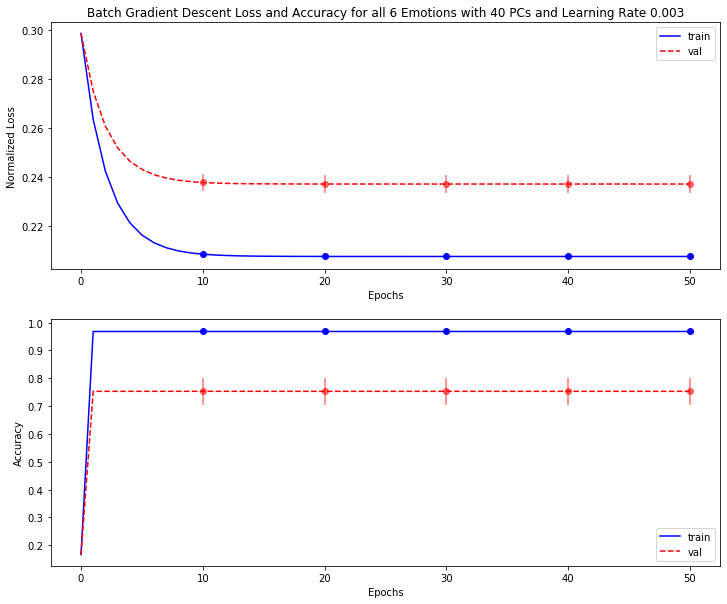

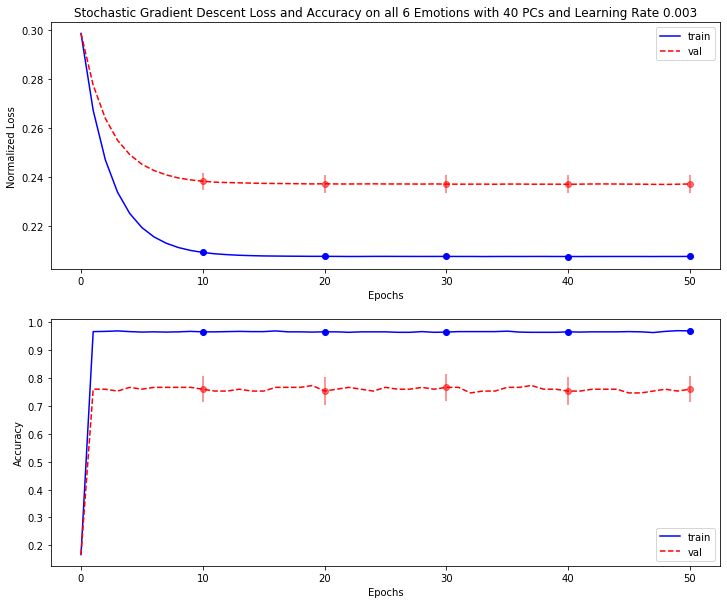

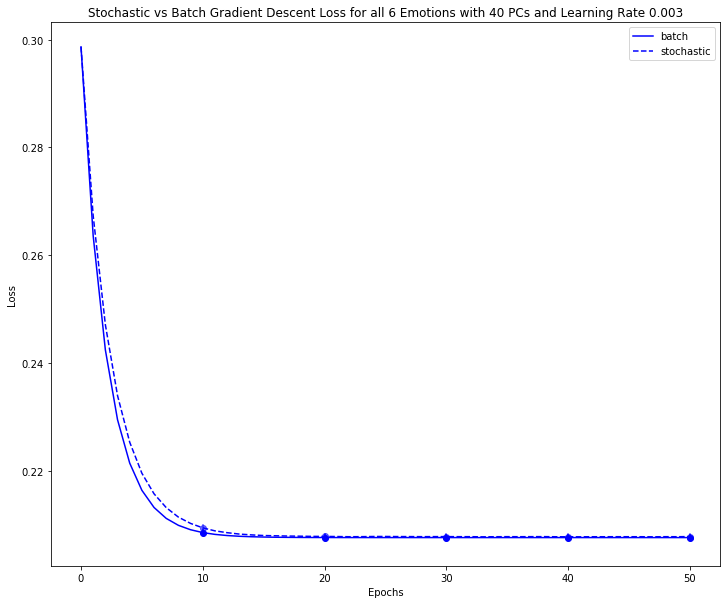

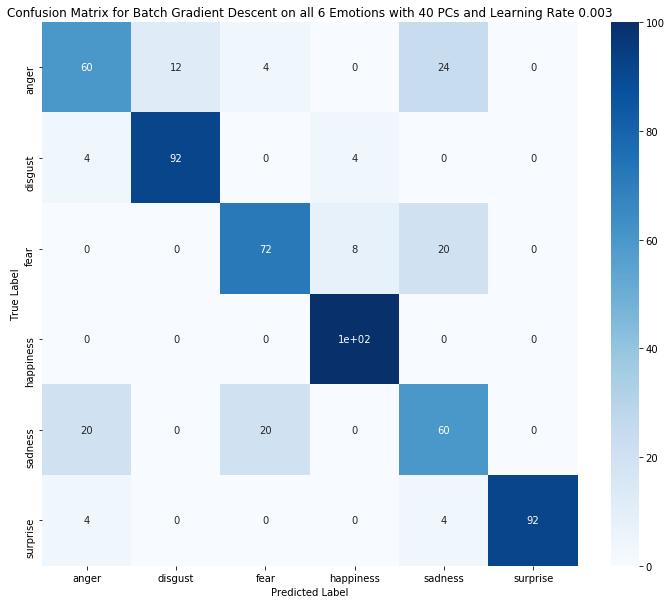

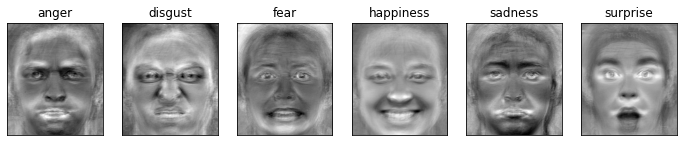

In [20]:
num_pcs = 40
learning_rate = 0.003
cross_folds = 10
epochs = 50
softmax_regression(num_pcs, learning_rate, cross_folds, epochs)